### Dependencies

In [1]:
!pip install keras-rectified-adam
!pip install segmentation-models

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=74f7213212fd44436f30915ba9a7ce7ca9a4438dde1fa8138b45240e2e8f84b3
  Stored in directory: /tmp/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam
     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 


In [2]:
import os
import cv2
import math
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import multiprocessing as mp
import albumentations as albu
from keras_radam import RAdam
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras import backend as K
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


### Load data

In [3]:
train = pd.read_csv('../input/understanding_cloud_organization/train.csv')
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')

hold_out_set = pd.read_csv('../input/clouds-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']

print('Compete set samples:', len(train))
print('Train samples: ', len(X_train))
print('Validation samples: ', len(X_val))
print('Test samples:', len(submission))

# Preprocecss data
train['image'] = train['Image_Label'].apply(lambda x: x.split('_')[0])
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])
test['set'] = 'test'

display(X_train.head())

Compete set samples: 22184
Train samples:  4420
Validation samples:  1105
Test samples: 14792


,image,Fish_mask,Flower_mask,Gravel_mask,Sugar_mask,Fish,Flower,Gravel,Sugar,set
0,66cda54.jpg,NaN,NaN,NaN,18208 624 19608 624 21008 624 22408 624 23808 ...,0,0,0,1,train
1,61d6640.jpg,NaN,NaN,1349079 387 1350479 387 1351879 387 1353279 38...,373839 334 375239 334 376639 334 378039 334 37...,0,0,1,1,train
2,bb31239.jpg,29 604 1429 604 2829 604 4229 604 5629 604 702...,1692065 510 1693465 510 1694865 510 1696265 51...,NaN,NaN,1,1,0,0,train
3,74d06fc.jpg,NaN,NaN,1435419 454 1436819 454 1438219 454 1439619 45...,NaN,0,0,1,0,train
4,f13cbe0.jpg,330457 1020 331857 1020 333257 1020 334657 102...,390661 1208 392061 1208 393461 1208 394861 120...,1629705 16 1629722 1144 1631105 16 1631122 4 1...,2561203 314 2562603 314 2564003 314 2565403 31...,1,1,1,1,train


# Model parameters

In [4]:
BACKBONE = 'densenet169'
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 3e-4
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
N_CLASSES = 4
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

model_name = 'uNet_%s_%sx%s' % (BACKBONE, HEIGHT, WIDTH)
model_path = '../working/%s' % (model_name)
submission_path = model_name +'_submission.csv'
submission_post_path = model_name + '_submission_post.csv'

In [5]:
preprocessing = sm.backbones.get_preprocessing(BACKBONE)

augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
                             albu.VerticalFlip(p=0.5),
                             albu.GridDistortion(p=0.5),
                             albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=45, 
                                                   shift_limit=0.1, border_mode=0, p=0.5),
                             albu.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
                             albu.Rotate(limit=45, p=0.5)
                            ])

### Auxiliary functions

In [6]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))
    
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    mask = np.zeros( width*height ).astype(np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def post_process(probability, threshold=0.5, min_size=10000):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros(probability.shape, np.float32)
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
    return predictions

def preprocess_image(image_id, base_path, save_path, HEIGHT=HEIGHT, WIDTH=WIDTH):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (WIDTH, HEIGHT))
    cv2.imwrite(save_path + image_id, image)
        
def preprocess_data(df, HEIGHT=HEIGHT, WIDTH=WIDTH):
    df = df.reset_index()
    for i in range(df.shape[0]):
        item = df.iloc[i]
        image_id = item['image']
        item_set = item['set']
        if item_set == 'train':
            preprocess_image(image_id, train_base_path, train_images_dest_path)
        if item_set == 'validation':
            preprocess_image(image_id, train_base_path, validation_images_dest_path)
        if item_set == 'test':
            preprocess_image(image_id, test_base_path, test_images_dest_path)
    
def pre_process_set(df, preprocess_fn):
    n_cpu = mp.cpu_count()
    df_n_cnt = df.shape[0]//n_cpu
    pool = mp.Pool(n_cpu)
    
    dfs = [df.iloc[df_n_cnt*i:df_n_cnt*(i+1)] for i in range(n_cpu)]
    dfs[-1] = df.iloc[df_n_cnt*(n_cpu-1):]
    res = pool.map(preprocess_fn, [x_df for x_df in dfs])
    pool.close()
            
def get_metrics(model, df, df_images_dest_path, tresholds, min_mask_sizes, set_name='Complete set'):
    class_names = ['Fish', 'Flower', 'Gravel', 'Sugar']
    metrics = []

    for class_name in class_names:
        metrics.append([class_name, 0, 0])

    metrics_df = pd.DataFrame(metrics, columns=['Class', 'Dice', 'Dice Post'])
    
    for i in range(0, df.shape[0], 500):
        batch_idx = list(range(i, min(df.shape[0], i + 500)))
        batch_set = df[batch_idx[0]: batch_idx[-1]+1]
        ratio = len(batch_set) / len(df)

        generator = DataGenerator(
                      directory=df_images_dest_path,
                      dataframe=batch_set,
                      target_df=train,
                      batch_size=len(batch_set), 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='fit',
                      shuffle=False)

        x, y = generator.__getitem__(0)
        preds = model.predict(x)
        
        for class_index in range(N_CLASSES):
            class_score = []
            class_score_post = []
            mask_class = y[..., class_index]
            pred_class = preds[..., class_index]
            for index in range(len(batch_idx)):
                sample_mask = mask_class[index, ]
                sample_pred = pred_class[index, ]
                sample_pred_post = post_process(sample_pred, threshold=tresholds[class_index], min_size=min_mask_sizes[class_index])
                if (sample_mask.sum() == 0) & (sample_pred.sum() == 0):
                    dice_score = 1.
                else:
                    dice_score = dice_coefficient(sample_pred, sample_mask)
                if (sample_mask.sum() == 0) & (sample_pred_post.sum() == 0):
                    dice_score_post = 1.
                else:
                    dice_score_post = dice_coefficient(sample_pred_post, sample_mask)
                class_score.append(dice_score)
                class_score_post.append(dice_score_post)
            metrics_df.loc[metrics_df['Class'] == class_names[class_index], 'Dice'] += np.mean(class_score) * ratio
            metrics_df.loc[metrics_df['Class'] == class_names[class_index], 'Dice Post'] += np.mean(class_score_post) * ratio

    metrics_df = metrics_df.append({'Class':set_name, 'Dice':np.mean(metrics_df['Dice'].values), 'Dice Post':np.mean(metrics_df['Dice Post'].values)}, ignore_index=True).set_index('Class')
    
    return metrics_df

def plot_metrics(history):
    fig, axes = plt.subplots(4, 1, sharex='col', figsize=(22, 14))
    axes = axes.flatten()
    
    axes[0].plot(history['loss'], label='Train loss')
    axes[0].plot(history['val_loss'], label='Validation loss')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(history['iou_score'], label='Train IOU Score')
    axes[1].plot(history['val_iou_score'], label='Validation IOU Score')
    axes[1].legend(loc='best')
    axes[1].set_title('IOU Score')

    axes[2].plot(history['dice_coef'], label='Train Dice coefficient')
    axes[2].plot(history['val_dice_coef'], label='Validation Dice coefficient')
    axes[2].legend(loc='best')
    axes[2].set_title('Dice coefficient')

    axes[3].plot(history['score'], label='Train F-Score')
    axes[3].plot(history['val_score'], label='Validation F-Score')
    axes[3].legend(loc='best')
    axes[3].set_title('F-Score')

    plt.xlabel('Epochs')
    sns.despine()
    plt.show()

## Pre-process data

In [7]:
train_base_path = '../input/understanding_cloud_organization/train_images/'
test_base_path = '../input/understanding_cloud_organization/test_images/'
train_images_dest_path = 'base_dir/train_images/'
validation_images_dest_path = 'base_dir/validation_images/'
test_images_dest_path = 'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_images_dest_path)
os.makedirs(validation_images_dest_path)
os.makedirs(test_images_dest_path)

# Pre-procecss train set
pre_process_set(X_train, preprocess_data)

# Pre-procecss validation set
pre_process_set(X_val, preprocess_data)

# Pre-procecss test set
pre_process_set(test, preprocess_data)

### Data generator

In [8]:
class DataGenerator(Sequence):
    def __init__(self, dataframe, target_df=None, mode='fit', directory=train_images_dest_path,
                 batch_size=BATCH_SIZE, n_channels=CHANNELS, target_size=(HEIGHT, WIDTH), 
                 n_classes=N_CLASSES, seed=seed, shuffle=True, preprocessing=None, augmentation=None):
        
        self.batch_size = batch_size
        self.dataframe = dataframe
        self.mode = mode
        self.directory = directory
        self.target_df = target_df
        self.target_size = target_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.seed = seed
        self.mask_shape = (1400, 2100)
        self.list_IDs = self.dataframe.index
        
        if self.seed is not None:
            np.random.seed(self.seed)
        
        self.on_epoch_end()

    def __len__(self):
        return len(self.list_IDs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            Y = self.__generate_Y(list_IDs_batch)
            
            if self.augmentation:
                X, Y = self.__augment_batch(X, Y)
            
            return X, Y
        
        elif self.mode == 'predict':
            return X
        
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        X = np.empty((self.batch_size, *self.target_size, self.n_channels))
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            img_path = self.directory + img_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.preprocessing:
                img = self.preprocessing(img)
                
            X[i,] = img

        return X
    
    def __generate_Y(self, list_IDs_batch):
        Y = np.empty((self.batch_size, *self.target_size, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            img_name = self.dataframe['image'].loc[ID]
            image_df = self.target_df[self.target_df['image'] == img_name]
            rles = image_df['EncodedPixels'].values
            masks = build_masks(rles, input_shape=self.mask_shape, reshape=self.target_size)
            Y[i, ] = masks

        return Y
    
    def __augment_batch(self, X_batch, Y_batch):
        for i in range(X_batch.shape[0]):
            X_batch[i, ], Y_batch[i, ] = self.__random_transform(X_batch[i, ], Y_batch[i, ])
        
        return X_batch, Y_batch
    
    def __random_transform(self, X, Y):
        composed = self.augmentation(image=X, mask=Y)
        X_aug = composed['image']
        Y_aug = composed['mask']
        
        return X_aug, Y_aug
    
train_generator = DataGenerator(
                  directory=train_images_dest_path,
                  dataframe=X_train,
                  target_df=train,
                  batch_size=BATCH_SIZE,
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  augmentation=augmentation,
                  seed=seed)

valid_generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=X_val,
                  target_df=train,
                  batch_size=BATCH_SIZE, 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed)

# Model

In [9]:
model = sm.Unet(backbone_name=BACKBONE, 
                encoder_weights='imagenet',
                classes=N_CLASSES,
                activation='sigmoid',
                input_shape=(HEIGHT, WIDTH, CHANNELS))

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

metric_list = [dice_coef, sm.metrics.iou_score, sm.metrics.f1_score]
callback_list = [checkpoint, es, rlrop]
optimizer = RAdam(learning_rate=LEARNING_RATE, warmup_proportion=0.1)

model.compile(optimizer=optimizer, loss=sm.losses.bce_dice_loss, metrics=metric_list)
model.summary()

51879936/51877672 [==============================] - 1s 0us/step
Model: "u-densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________

In [10]:
STEP_SIZE_TRAIN = len(X_train)//BATCH_SIZE
STEP_SIZE_VALID = len(X_val)//BATCH_SIZE

history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              callbacks=callback_list,
                              epochs=EPOCHS,
                              verbose=2).history

Epoch 1/30
 - 295s - loss: 1.5134 - dice_coef: 0.2520 - iou_score: 0.1150 - score: 0.1794 - val_loss: 1.6372 - val_dice_coef: 0.2622 - val_iou_score: 0.1211 - val_score: 0.1877
Epoch 2/30
 - 226s - loss: 1.3020 - dice_coef: 0.2990 - iou_score: 0.1281 - score: 0.1956 - val_loss: 1.2688 - val_dice_coef: 0.3135 - val_iou_score: 0.1374 - val_score: 0.2083
Epoch 3/30
 - 247s - loss: 1.1981 - dice_coef: 0.3427 - iou_score: 0.1421 - score: 0.2124 - val_loss: 1.2156 - val_dice_coef: 0.3620 - val_iou_score: 0.1533 - val_score: 0.2263
Epoch 4/30
 - 237s - loss: 1.1302 - dice_coef: 0.3827 - iou_score: 0.1544 - score: 0.2261 - val_loss: 1.1407 - val_dice_coef: 0.3877 - val_iou_score: 0.1640 - val_score: 0.2398
Epoch 5/30
 - 244s - loss: 1.0922 - dice_coef: 0.4086 - iou_score: 0.1600 - score: 0.2317 - val_loss: 1.1548 - val_dice_coef: 0.4177 - val_iou_score: 0.1785 - val_score: 0.2549
Epoch 6/30
 - 235s - loss: 1.0727 - dice_coef: 0.4269 - iou_score: 0.1663 - score: 0.2385 - val_loss: 1.0469 - val_

## Model loss graph

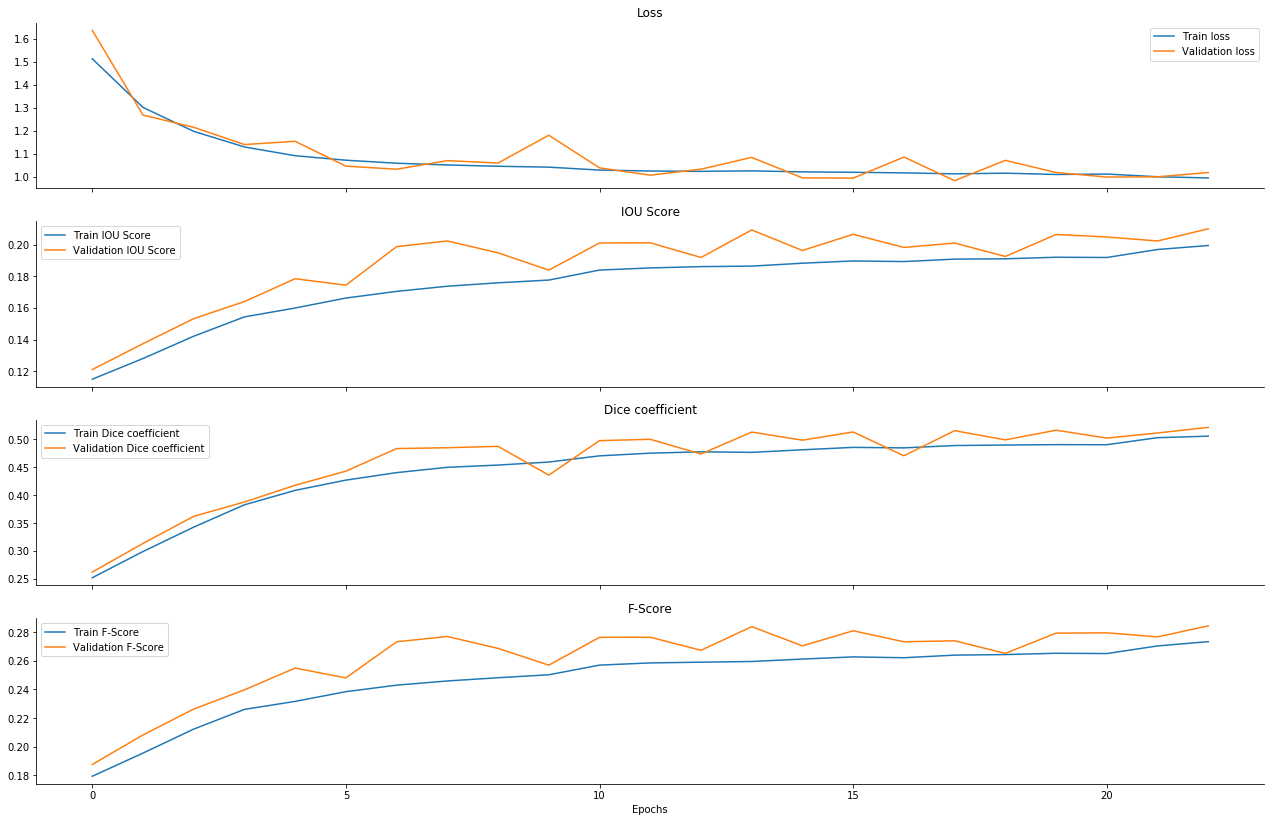

In [11]:
plot_metrics(history)

# Threshold and mask size tunning

In [12]:
class_names = ['Fish  ', 'Flower', 'Gravel', 'Sugar ']
mask_grid = [0, 500, 1000, 5000, 7500, 10000, 15000]
threshold_grid = np.arange(.5, 1, .05)
metrics = []

for class_index in range(N_CLASSES):
    for threshold in threshold_grid:
        for mask_size in mask_grid:
            metrics.append([class_index, threshold, mask_size, 0])

metrics_df = pd.DataFrame(metrics, columns=['Class', 'Threshold', 'Mask size', 'Dice'])

for i in range(0, X_val.shape[0], 500):
    batch_idx = list(range(i, min(X_val.shape[0], i + 500)))
    batch_set = X_val[batch_idx[0]: batch_idx[-1]+1]
    ratio = len(batch_set) / len(X_val)
    
    generator = DataGenerator(
                  directory=validation_images_dest_path,
                  dataframe=batch_set,
                  target_df=train,
                  batch_size=len(batch_set), 
                  target_size=(HEIGHT, WIDTH),
                  n_channels=CHANNELS,
                  n_classes=N_CLASSES,
                  preprocessing=preprocessing,
                  seed=seed,
                  mode='fit',
                  shuffle=False)
    
    x, y = generator.__getitem__(0)
    preds = model.predict(x)

    for class_index in range(N_CLASSES):
        class_score = []
        label_class = y[..., class_index]
        pred_class = preds[..., class_index]
        for threshold in threshold_grid:
            for mask_size in mask_grid:
                mask_score = []
                for index in range(len(batch_idx)):
                    label_mask = label_class[index, ]
                    pred_mask = pred_class[index, ]
                    pred_mask = post_process(pred_mask, threshold=threshold, min_size=mask_size)
                    dice_score = dice_coefficient(pred_mask, label_mask)
                    if (pred_mask.sum() == 0) & (label_mask.sum() == 0):
                        dice_score = 1.
                    mask_score.append(dice_score)
                metrics_df.loc[(metrics_df['Class'] == class_index) & (metrics_df['Threshold'] == threshold) & 
                               (metrics_df['Mask size'] == mask_size), 'Dice'] += np.mean(mask_score) * ratio

metrics_df_0 = metrics_df[metrics_df['Class'] == 0]
metrics_df_1 = metrics_df[metrics_df['Class'] == 1]
metrics_df_2 = metrics_df[metrics_df['Class'] == 2]
metrics_df_3 = metrics_df[metrics_df['Class'] == 3]

optimal_values_0 = metrics_df_0.loc[metrics_df_0['Dice'].idxmax()].values
optimal_values_1 = metrics_df_1.loc[metrics_df_1['Dice'].idxmax()].values
optimal_values_2 = metrics_df_2.loc[metrics_df_2['Dice'].idxmax()].values
optimal_values_3 = metrics_df_3.loc[metrics_df_3['Dice'].idxmax()].values

best_tresholds = [optimal_values_0[1], optimal_values_1[1], optimal_values_2[1], optimal_values_3[1]]
best_masks = [optimal_values_0[2], optimal_values_1[2], optimal_values_2[2], optimal_values_3[2]]
best_dices = [optimal_values_0[3], optimal_values_1[3], optimal_values_2[3], optimal_values_3[3]]

for index, name in enumerate(class_names):
    print('%s treshold=%.2f mask size=%d Dice=%.3f' % (name, best_tresholds[index], best_masks[index], best_dices[index]))

Fish   treshold=0.55 mask size=5000 Dice=0.589
Flower treshold=0.55 mask size=5000 Dice=0.748
Gravel treshold=0.50 mask size=10000 Dice=0.583
Sugar  treshold=0.50 mask size=5000 Dice=0.580


# Model evaluation

In [13]:
train_metrics = get_metrics(model, X_train, train_images_dest_path, best_tresholds, best_masks, 'Train')
display(train_metrics)

validation_metrics = get_metrics(model, X_val, validation_images_dest_path, best_tresholds, best_masks, 'Validation')
display(validation_metrics)

,Dice,Dice Post
Class,,
Fish,0.214286,0.621812
Flower,0.194348,0.765334
Gravel,0.219994,0.603999
Sugar,0.248904,0.581249
Train,0.219383,0.643099


,Dice,Dice Post
Class,,
Fish,0.217406,0.589180
Flower,0.203403,0.747636
Gravel,0.215694,0.583416
Sugar,0.249814,0.580307
Validation,0.221579,0.625135


# Apply model to test set

In [14]:
test_df = []

for i in range(0, test.shape[0], 500):
    batch_idx = list(range(i, min(test.shape[0], i + 500)))
    batch_set = test[batch_idx[0]: batch_idx[-1]+1]
    
    test_generator = DataGenerator(
                      directory=test_images_dest_path,
                      dataframe=batch_set,
                      target_df=submission,
                      batch_size=1, 
                      target_size=(HEIGHT, WIDTH),
                      n_channels=CHANNELS,
                      n_classes=N_CLASSES,
                      preprocessing=preprocessing,
                      seed=seed,
                      mode='predict',
                      shuffle=False)
    
    preds = model.predict_generator(test_generator)

    for index, b in enumerate(batch_idx):
        filename = test['image'].iloc[b]
        image_df = submission[submission['image'] == filename].copy()
        pred_masks = preds[index, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))
        image_df['EncodedPixels'] = pred_rles

        ### Post procecssing
        pred_masks_post = preds[index, ].astype('float32') 
        for class_index in range(N_CLASSES):
            pred_mask = pred_masks_post[...,class_index]
            pred_mask = post_process(pred_mask, threshold=best_tresholds[class_index], min_size=best_masks[class_index])
            pred_masks_post[...,class_index] = pred_mask

        pred_rles_post = build_rles(pred_masks_post, reshape=(350, 525))
        image_df['EncodedPixels_post'] = pred_rles_post
        ###
        
        test_df.append(image_df)

sub_df = pd.concat(test_df)

### Regular submission

In [15]:
submission_df = sub_df[['Image_Label' ,'EncodedPixels']]
submission_df.to_csv('submission.csv', index=False)
display(submission_df.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,10 221 242 10 255 20 360 221 592 10 605 20 710...
3,002f507.jpg_Sugar,153121 3 153471 3 153821 3 154171 3 154521 3 1...
4,0035ae9.jpg_Fish,85908 5 86258 5 86599 4 86608 9 86621 3 86949 ...


### Submission with post processing

In [16]:
submission_df_post = sub_df[['Image_Label' ,'EncodedPixels_post']]
submission_df_post.columns = ['Image_Label' ,'EncodedPixels']
submission_df_post.to_csv('submission_post.csv', index=False)
display(submission_df_post.head())

,Image_Label,EncodedPixels
0,002f507.jpg_Fish,
1,002f507.jpg_Flower,
2,002f507.jpg_Gravel,10 221 242 10 255 20 360 221 592 10 605 20 710...
3,002f507.jpg_Sugar,
4,0035ae9.jpg_Fish,


In [17]:
# Cleaning created directories
if os.path.exists(train_images_dest_path):
    shutil.rmtree(train_images_dest_path)
if os.path.exists(validation_images_dest_path):
    shutil.rmtree(validation_images_dest_path)
if os.path.exists(test_images_dest_path):
    shutil.rmtree(test_images_dest_path)